In [1]:
import pandas as pd
import numpy as np

# ============================================================
# USER SETTINGS
# ============================================================
MERGED_CSV = "isd_KHSE_only/KHSE_area_ISD_wind_merged.csv"  # <-- change if needed
GAP_FACTOR = 3.0                                           # gap = GAP_FACTOR * median(dt)
CALM_MS = 1.0                                               # "calm" threshold (m/s)
NW_THRESHOLDS_MS = [5, 10, 15, 20]                          # thresholds for NW exceedance
NW_EVENT_DURS_H = [6, 12, 24, 48, 72]                       # persistence bins (hours)

# ============================================================
# LOAD
# ============================================================
wind = pd.read_csv(MERGED_CSV, parse_dates=["time"])
wind = wind.sort_values("time").reset_index(drop=True)

print("------------------------------------------------------------")
print("FILE:", MERGED_CSV)
print("Rows:", len(wind))
print("Span:", wind["time"].min(), "to", wind["time"].max())
print("Columns:", list(wind.columns))
print("------------------------------------------------------------")

# ============================================================
# GAP ANALYSIS
# ============================================================
dt = wind["time"].diff().dt.total_seconds()
dt_nom = np.nanmedian(dt)
gap_thresh = GAP_FACTOR * dt_nom

gaps = wind.loc[dt > gap_thresh, ["time"]].copy()
gaps["gap_seconds"] = dt[dt > gap_thresh].values
gaps["gap_hours"] = gaps["gap_seconds"] / 3600.0
gaps["gap_days"] = gaps["gap_hours"] / 24.0

print(f"Nominal timestep (median): {dt_nom/3600:.2f} h")
print(f"Gap threshold:             {gap_thresh/3600:.2f} h  (={GAP_FACTOR:.1f}× nominal)")
print(f"Number of gaps:            {len(gaps)}")

if len(gaps) > 0:
    print("\nGap duration summary (hours):")
    print(gaps["gap_hours"].describe(percentiles=[0.5, 0.9, 0.99]))
    for h in [6, 12, 24, 72, 168]:
        print(f"Gaps > {h:4d} h: {np.sum(gaps['gap_hours'] > h)}")
else:
    print("No gaps above threshold detected.")

# ============================================================
# BASIC WIND STATISTICS
# ============================================================
spd = pd.to_numeric(wind.get("wind_speed_mps", np.nan), errors="coerce")
dirf = pd.to_numeric(wind.get("wind_dir_from_deg", np.nan), errors="coerce")

print("\n------------------------------------------------------------")
print("BASIC WIND STATS (full record)")
print("------------------------------------------------------------")
print(f"Mean speed (m/s):    {spd.mean():.3f}")
print(f"Median speed (m/s):  {spd.median():.3f}")
print(f"P90 speed (m/s):     {spd.quantile(0.90):.3f}")
print(f"P99 speed (m/s):     {spd.quantile(0.99):.3f}")
print(f"Max speed (m/s):     {spd.max():.3f}")
print(f"Calm fraction (<{CALM_MS:g} m/s): {np.mean(spd < CALM_MS):.4f}")

# ============================================================
# NW QUADRANT STATS
# NW winds defined as winds FROM 270..360 degrees (W through N)
# ============================================================
def is_nw(dir_from_deg):
    d = dir_from_deg % 360.0
    return (d >= 270.0) & (d <= 360.0)

wind["is_NW"] = is_nw(dirf)

nw_frac = wind["is_NW"].mean()
print("\n------------------------------------------------------------")
print("NW QUADRANT STATS (winds FROM 270..360 deg)")
print("------------------------------------------------------------")
print(f"NW fraction of all observations: {nw_frac:.4f}")

for thr in NW_THRESHOLDS_MS:
    frac = np.mean(wind["is_NW"] & (spd >= thr))
    print(f"NW & speed ≥ {thr:2d} m/s: {frac:.4f}")

# ============================================================
# NW PERSISTENCE (continuous runs of NW winds)
# ============================================================
is_nw_arr = wind["is_NW"].values
time_arr = wind["time"].values

events = []
in_event = False
t0 = None

for i in range(len(wind)):
    if is_nw_arr[i] and not in_event:
        in_event = True
        t0 = time_arr[i]
    elif (not is_nw_arr[i]) and in_event:
        t1 = time_arr[i-1]
        events.append((t0, t1))
        in_event = False

if in_event:
    events.append((t0, time_arr[-1]))

events = pd.DataFrame(events, columns=["start", "end"])
if len(events) > 0:
    events["duration_h"] = (events["end"] - events["start"]).dt.total_seconds() / 3600.0

print("\n------------------------------------------------------------")
print("NW EVENT PERSISTENCE")
print("------------------------------------------------------------")
print("Number of NW events:", len(events))

if len(events) > 0:
    print(events["duration_h"].describe(percentiles=[0.5, 0.9, 0.99]))
    for h in NW_EVENT_DURS_H:
        print(f"NW events ≥ {h:3d} h: {np.sum(events['duration_h'] >= h)}")
else:
    print("No NW events found (unexpected unless record is very short).")

# ============================================================
# OPTIONAL: YEARLY SUMMARIES
# ============================================================
wind["year"] = wind["time"].dt.year

annual = wind.groupby("year").agg(
    mean_speed_mps=("wind_speed_mps", "mean"),
    p95_speed_mps=("wind_speed_mps", lambda x: np.nanquantile(x, 0.95)),
    nw_fraction=("is_NW", "mean"),
    nw_speed_ge_10=("wind_speed_mps", lambda x: np.mean(wind.loc[x.index, "is_NW"] & (x >= 10)))
).reset_index()

print("\n------------------------------------------------------------")
print("ANNUAL SUMMARY (first 10 rows)")
print("------------------------------------------------------------")
print(annual.head(10).to_string(index=False))

# If you want the full annual table saved:
annual.to_csv("KHSE_wind_annual_summary.csv", index=False)
if len(gaps) > 0:
    gaps.to_csv("KHSE_wind_gaps.csv", index=False)
if len(events) > 0:
    events.to_csv("KHSE_NW_events.csv", index=False)

print("\nWrote: KHSE_wind_annual_summary.csv, KHSE_wind_gaps.csv (if any), KHSE_NW_events.csv (if any)")


------------------------------------------------------------
FILE: isd_KHSE_only/KHSE_area_ISD_wind_merged.csv
Rows: 623597
Span: 1957-03-01 05:00:00+00:00 to 2025-08-27 04:59:00+00:00
Columns: ['time', 'wind_dir_from_deg', 'wind_speed_mps', 'usafwban']
------------------------------------------------------------
Nominal timestep (median): 1.00 h
Gap threshold:             3.00 h  (=3.0× nominal)
Number of gaps:            52

Gap duration summary (hours):
count    52.000000
mean     12.641026
std       9.287840
min       3.150000
50%      10.000000
90%      24.000000
99%      43.928500
max      48.000000
Name: gap_hours, dtype: float64
Gaps >    6 h: 36
Gaps >   12 h: 20
Gaps >   24 h: 2
Gaps >   72 h: 0
Gaps >  168 h: 0

------------------------------------------------------------
BASIC WIND STATS (full record)
------------------------------------------------------------
Mean speed (m/s):    4.506
Median speed (m/s):  4.100
P90 speed (m/s):     7.700
P99 speed (m/s):     11.300
Max s

C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_16592\4210306871.py:41: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  spd_all_6h = wind["wind_speed_mps"].resample(rule).max()
C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_16592\4210306871.py:44: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  spd_nw_6h = wind["wind_speed_mps"].where(is_nw).resample(rule).max()


Decimated points: 100065
Span: 1957-03-01 00:00:00+00:00 to 2025-08-27 00:00:00+00:00
                           spd_all_6h_max_mps  spd_nw_6h_max_mps
time                                                            
1957-03-01 00:00:00+00:00                 5.2                5.2
1957-03-01 06:00:00+00:00                 5.7                5.7
1957-03-01 12:00:00+00:00                 4.1                4.1
1957-03-01 18:00:00+00:00                 6.7                6.7
1957-03-02 00:00:00+00:00                 6.7                6.7


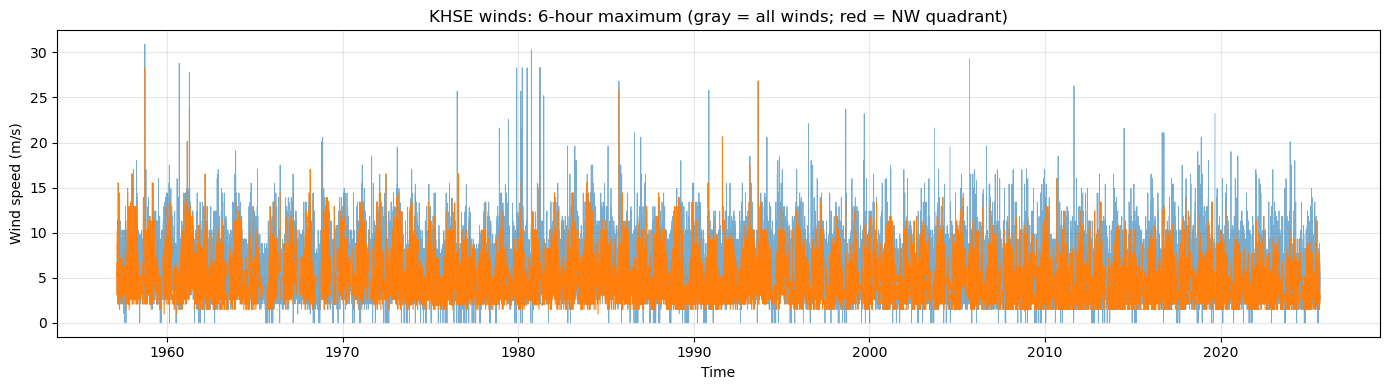

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# USER SETTINGS
# ============================================================
MERGED_CSV = "isd_KHSE_only/KHSE_area_ISD_wind_merged.csv"  # <-- change if needed
BIN_HOURS = 6                                               # max-filter window / decimation interval
NW_DIR_MIN = 270.0                                          # NW quadrant (FROM degrees)
NW_DIR_MAX = 360.0

# ============================================================
# LOAD + CLEAN
# ============================================================
wind = pd.read_csv(MERGED_CSV, parse_dates=["time"])
wind = wind.sort_values("time").reset_index(drop=True)

wind["wind_speed_mps"] = pd.to_numeric(wind["wind_speed_mps"], errors="coerce")
wind["wind_dir_from_deg"] = pd.to_numeric(wind["wind_dir_from_deg"], errors="coerce")

# Drop rows without valid time or speed
wind = wind.dropna(subset=["time", "wind_speed_mps"]).copy()

# Use time index for resampling
wind = wind.set_index("time")

# ============================================================
# NW QUADRANT MASK (FROM 270..360)
# ============================================================
d = wind["wind_dir_from_deg"] % 360.0
is_nw = (d >= NW_DIR_MIN) & (d <= NW_DIR_MAX)

# ============================================================
# 6-HOUR MAX FILTER + DECIMATE
# - Whole series: max wind speed in each 6-hour bin
# - NW series: max wind speed in each 6-hour bin, but only considering NW samples
# ============================================================
rule = f"{BIN_HOURS}H"

spd_all_6h = wind["wind_speed_mps"].resample(rule).max()

# For NW-only maxima, mask non-NW to NaN before resampling
spd_nw_6h = wind["wind_speed_mps"].where(is_nw).resample(rule).max()

# Combine for convenient plotting/inspection
dec = pd.DataFrame({
    "spd_all_6h_max_mps": spd_all_6h,
    "spd_nw_6h_max_mps": spd_nw_6h
})

print("Decimated points:", len(dec))
print("Span:", dec.index.min(), "to", dec.index.max())
print(dec.head())

# ============================================================
# PLOT: gray full series, red NW-only series
# ============================================================
plt.figure(figsize=(14, 4))

# Whole time series (6h max) in gray
plt.plot(dec.index, dec["spd_all_6h_max_mps"], linewidth=0.6, alpha=0.6)

# NW maxima (6h max) in red (only where it exists)
plt.plot(dec.index, dec["spd_nw_6h_max_mps"], linewidth=0.8)

plt.xlabel("Time")
plt.ylabel("Wind speed (m/s)")
plt.title(f"KHSE winds: {BIN_HOURS}-hour maximum (gray = all winds; red = NW quadrant)")
plt.grid(True, which="both", alpha=0.3)

plt.tight_layout()
plt.show()
